In [1]:
import pandas as pd
import numpy as np

from numpy.random import seed

from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
OUTPUT_PATH = './Data/output/'

### Import dataset

In [99]:
dataset_raw = pd.read_csv(OUTPUT_PATH + 'CleanData_Population_Schools_SDGs.csv')
dataset = dataset_raw.dropna()
dataset.head()

,PSGC_BRGY,both_age_0_to_4,male_age_0_to_4,female_age_0_to_4,both_age_5_to_9,male_age_5_to_9,female_age_5_to_9,both_age_10_to_14,male_age_10_to_14,female_age_10_to_14,...,SDG_Type_Worker_Pro,SDG_Type_Worker_Tec,SDG_Type_Worker_Cle,SDG_Type_Worker_Ser,SDG_Type_Worker_Ski,SDG_Type_Worker_Cra,SDG_Type_Worker_Pla,SDG_Type_Worker_Ele,SDG_Type_Worker_Arm,SDG_less_than_54_sqft
0,PH150702001,88.0,54.0,34.0,79.0,35.0,44.0,73.0,42.0,31.0,...,0.042654,0.014218,0.085308,0.208531,0.507109,0.033175,0.014218,0.052133,0.023697,0.275449
1,PH150702002,210.0,100.0,110.0,161.0,77.0,84.0,133.0,69.0,64.0,...,0.047619,0.002976,0.011905,0.047619,0.529762,0.053571,0.119048,0.113095,0.000000,0.287554
3,PH150702005,277.0,152.0,125.0,305.0,159.0,146.0,269.0,155.0,114.0,...,0.051637,0.021411,0.040302,0.070529,0.488665,0.032746,0.059194,0.164987,0.011335,0.002092
4,PH150702006,352.0,146.0,206.0,354.0,201.0,153.0,398.0,217.0,181.0,...,0.016966,0.002994,0.023952,0.106786,0.525948,0.019960,0.048902,0.171657,0.004990,0.061657
5,PH150702007,270.0,140.0,130.0,236.0,114.0,122.0,220.0,121.0,99.0,...,0.026316,0.011696,0.023392,0.084795,0.494152,0.081871,0.125731,0.096491,0.010234,0.391509


### Preprocess data

In [4]:
SDG = dataset.iloc[:,84:]

#### 1. Elementary

In [126]:
data_elem = SDG.copy()
data_elem['NUM_SCHOOLS'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS'] + dataset['SCH_CAT_PES']
data_elem['ELEM_POPN'] = dataset['both_age_6_to_12']
len(data_elem)

1529

In [127]:
zero_schools_elem = data_elem[data_elem['NUM_SCHOOLS'] == 0]
data_elem = data_elem[data_elem['NUM_SCHOOLS'] != 0]
len(data_elem)

1488

#### 2. High School

In [150]:
data_hs = SDG.copy()
data_hs['NUM_SCHOOLS'] = dataset['SCH_CAT_JHS'] + dataset['SCH_CAT_SHS'] + dataset['SCH_CAT_PJHS'] + dataset['SCH_CAT_PSHS']
data_hs['HS_POPN'] = dataset['both_age_13_to_16']
len(data_hs)

1529

In [151]:
zero_schools_hs = data_hs[data_hs['NUM_SCHOOLS'] == 0]
data_hs = data_hs[data_hs['NUM_SCHOOLS'] != 0]
len(data_hs)

320

In [152]:
training_data, testing_data = train_test_split(data_hs, test_size=0.2, random_state=42)

In [153]:
X_train = training_data.drop(['NUM_SCHOOLS'], axis=1)
y_train = training_data['NUM_SCHOOLS']

X_test = testing_data.drop(['NUM_SCHOOLS'], axis=1)
y_test = testing_data['NUM_SCHOOLS']

In [154]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [155]:
def base_model():
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(4, input_dim=2, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
#     model.add(Dense(20, activation='tanh', input_dim=5, kernel_initializer='uniform'))
#     model.add(Dense(1, activation='linear', kernel_initializer='uniform'))
    
    model.compile(loss='mse', optimizer='adam')
    return model

In [156]:
model = base_model()
EPOCHS = 200
BATCH_SIZE = 10

seed(1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=callback)

Epoch 1/200
21/21 [==============================] - 1s 9ms/step - loss: 1.1569 - val_loss: 0.4576
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 1.1767 - val_loss: 0.3918
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 1.2996 - val_loss: 0.3345
Epoch 4/200
21/21 [==============================] - 0s 2ms/step - loss: 1.0875 - val_loss: 0.2877
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 0.8973 - val_loss: 0.2475
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6890 - val_loss: 0.2135
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 0.8946 - val_loss: 0.1817
Epoch 8/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.1597
Epoch 9/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6287 - val_loss: 0.1464
Epoch 10/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5146 - val_loss: 0.1399
Epoch 11/

21/21 [==============================] - 0s 3ms/step - loss: 0.2360 - val_loss: 0.1064
Epoch 84/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1440 - val_loss: 0.1003
Epoch 85/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1840 - val_loss: 0.1035
Epoch 86/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.1042
Epoch 87/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1437 - val_loss: 0.1046
Epoch 88/200
21/21 [==============================] - 0s 3ms/step - loss: 0.2104 - val_loss: 0.1085
Epoch 89/200
21/21 [==============================] - 0s 3ms/step - loss: 0.2931 - val_loss: 0.1076
Epoch 90/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1950 - val_loss: 0.1000
Epoch 91/200
21/21 [==============================] - 0s 3ms/step - loss: 0.2585 - val_loss: 0.1025
Epoch 92/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1999 - val_loss: 0.1049
Epoch 93/200


21/21 [==============================] - 0s 3ms/step - loss: 0.1197 - val_loss: 0.1255
Epoch 165/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1483 - val_loss: 0.1248
Epoch 166/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1382 - val_loss: 0.1280
Epoch 167/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1433 - val_loss: 0.1279
Epoch 168/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1235
Epoch 169/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0959 - val_loss: 0.1196
Epoch 170/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1155 - val_loss: 0.1218
Epoch 171/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1427 - val_loss: 0.1247
Epoch 172/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0971 - val_loss: 0.1298
Epoch 173/200
21/21 [==============================] - 0s 3ms/step - loss: 0.1585 - val_loss: 0.1150
Epoc

In [157]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
169,0.121125,0.121802,169
170,0.119566,0.124721,170
171,0.120900,0.129789,171
172,0.119618,0.115004,172
173,0.119803,0.120081,173


In [158]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

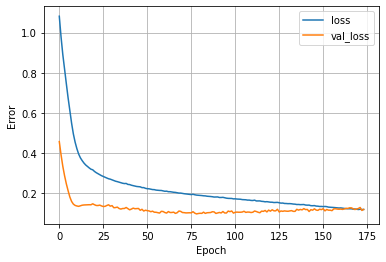

In [159]:
plot_loss(history)

In [160]:
y_pred = model.predict(X_test)

In [161]:
y_pred_round = np.round(y_pred)

In [162]:
accuracy_score(y_test, y_pred_round)

0.796875

In [163]:
model.save(OUTPUT_PATH + 'Model_NN_HS')

INFO:tensorflow:Assets written to: ./Data/output/Model_NN_HS\assets


### FEATURE IMPORTANCE

In [164]:
from sklearn.model_selection import cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor

import eli5
from eli5.sklearn import PermutationImportance

In [165]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)
kfold = KFold(n_splits=10)

In [166]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)

3/3 [==============================] - 0s 2ms/step - loss: 1.2363


In [167]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -0.99 (0.23) MSE


In [168]:
estimator.fit(X_train, y_train)

21/21 [==============================] - 0s 9ms/step - loss: 3.0122 - val_loss: 1.9600


In [169]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

26/26 [==============================] - 0s 754us/step - loss: 2.5911


Weight,Feature
0.2608 ± 0.0595,SDG_Households_Electricity_Light_Pct
0.2129 ± 0.0477,SDG_Type_Worker_Cle
0.0683 ± 0.0795,HS_POPN
0.0304 ± 0.0366,SDG_Type_Worker_Ele
0.0085 ± 0.0162,SDG_Building_Tenure_Type_Owned_Pct
-0.0041 ± 0.0266,SDG_less_than_54_sqft
-0.0113 ± 0.0236,SDG_Type_Worker_Cra
-0.0129 ± 0.0215,SDG_Type_Worker_Ski
-0.0214 ± 0.0118,SDG_Type_Worker_Pla
-0.0271 ± 0.0190,SDG_Type_Worker_Arm


### PREDICT BRGY WITHOUT SCHOOL

In [114]:
dataset_null = dataset_raw[dataset_raw.isnull().any(axis=1)]
len(dataset_null)

953

In [116]:
X_predict = dataset_null.iloc[:,84:]
X_predict['ELEM_POPN'] = dataset_null['both_age_6_to_12']

In [142]:
def predict(X_predict):
    y_pred_null = model.predict(X_predict)
    X_predict['Pred_school_num'] = np.round(y_pred_null)
    X_predict['PSGC_BRGY'] = dataset_null['PSGC_BRGY']
    return X_predict

In [143]:
pred_df_1 = predict(X_predict)

In [144]:
zero_schools = zero_schools_elem.drop(['NUM_SCHOOLS'], axis=1)
pred_df_2 = predict(zero_schools)

In [147]:
predicted_df = pd.concat([pred_df_1, pred_df_2])

In [148]:
len(predicted_df)

994

In [149]:
predicted_df.to_csv(OUTPUT_PATH + 'Model_NN_Output_Elem.csv', index=False)